In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Reshape
from keras.models import Model
from keras import backend as K, datasets
from keras.utils import plot_model
from tensorflow.keras import layers, Sequential
import keras as keras

# Get the Data

In [2]:
# load fashion_mnist dataset from tensorflow into a train and test dictionaries
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

In [3]:
ds1_emander = {'images': train_images, 'labels': train_labels}
ds2_emander = {'images': test_images, 'labels': test_labels}

# Data Pre-processing

In [4]:
# Take the largest pixel value for normalization
combined_images = np.concatenate((ds1_emander['images'], ds2_emander['images']), axis=0) 
largest_px_value = np.amax(combined_images)
print(f"Largest Pixel Value: {largest_px_value}")

Largest Pixel Value: 255


In [5]:
# Normalize the pixel values to range of 0-1
ds1_emander['images'] = ds1_emander['images'] / largest_px_value
ds2_emander['images'] = ds2_emander['images'] / largest_px_value

In [6]:
# Print the shapes of my datasets
print(f"ds1_emander Images Shape: {ds1_emander['images'].shape}")
print(f"ds2_emander Images Shape: {ds2_emander['images'].shape}")

ds1_emander Images Shape: (60000, 28, 28)
ds2_emander Images Shape: (10000, 28, 28)


In [7]:
# Only pants
pants_ds1_emander = ds1_emander['images'][ds1_emander['labels'] == 1]
pants_ds2_emander = ds2_emander['images'][ds2_emander['labels'] == 1]

In [8]:
dataset_emander = np.concatenate((pants_ds1_emander, pants_ds2_emander), axis=0)

In [9]:
dataset_emander.shape

(7000, 28, 28)

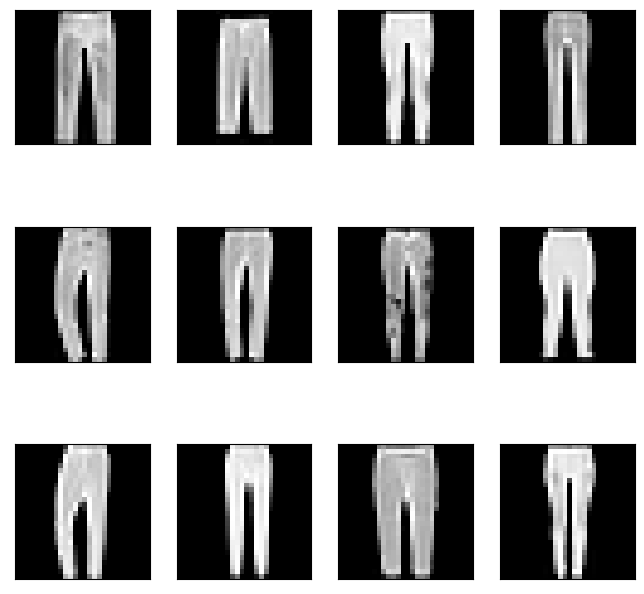

In [10]:
# Display first 12 images of train noisy dataset
plt.figure(figsize=(8,8))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(dataset_emander[i])
    plt.gray()
    plt.xticks([])
    plt.yticks([])
plt.show()

In [11]:
# Create a TensorFlow dataset from the numpy array of dataset_emander
train_dataset_emander = tf.data.Dataset.from_tensor_slices(dataset_emander)

In [12]:
# Shuffling the dataset with a buffer size larger than the dataset size
train_dataset_emander = train_dataset_emander.shuffle(10000)

In [13]:
# Batch the dataset with a size of 256
train_dataset_emander = train_dataset_emander.batch(256)

In [14]:
train_dataset_emander

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28), dtype=tf.float64, name=None)>

# Build the Generator Model of GAN

In [15]:
latent_dim = 100

generator_model_emander = Sequential(
    [
        layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(latent_dim,)), # Fully connected layer
        layers.Reshape((7, 7, 256)),
        layers.BatchNormalization(), # 2nd Layer
        layers.LeakyReLU(), # 3rd Layer
        layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(), # 5th Layer
        layers.LeakyReLU(), # 6th Layer
        layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(), # 8th Layer
        layers.LeakyReLU(), # 9th Layer
        layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ]
)

In [16]:
# Display the model's architecture
generator_model_emander.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 256)         1024      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

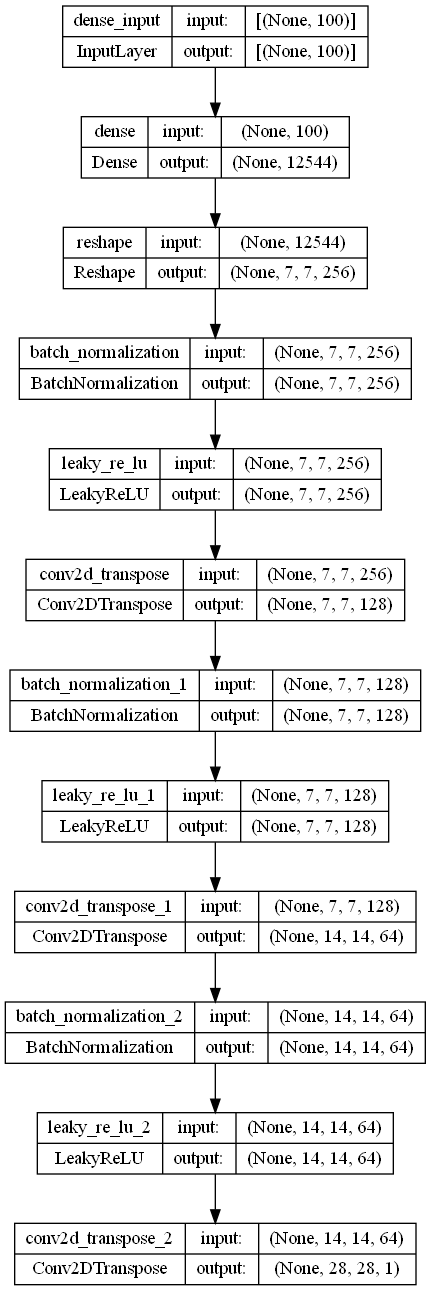

In [17]:
# Draw the diagram for the summary
plot_model(generator_model_emander, show_shapes=True, show_layer_names=True)

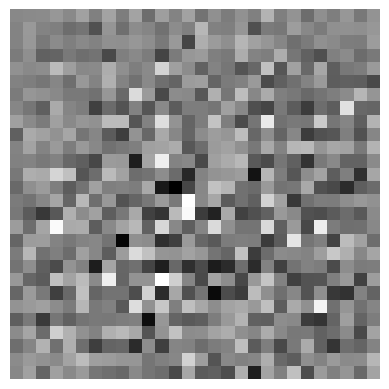

In [18]:
# Sampling the untrained generator
# Create a sample vector
noise = tf.random.normal([1, 100])

# Generate an image from the generator model
generated_image = generator_model_emander(noise, training=False)

# Display the generated image
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show()

# Build the Discriminator Model of GAN

In [19]:
discriminator_model_emander = Sequential(
    [
        layers.Conv2D(64, kernel_size=(5,5), strides=(2,2), padding='same', input_shape=(28,28,1)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, kernel_size=(5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2DTranspose(64, 5, padding='same', strides=2, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ]
)

In [20]:
# Display the model's architecture
discriminator_model_emander.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 14, 14, 64)       

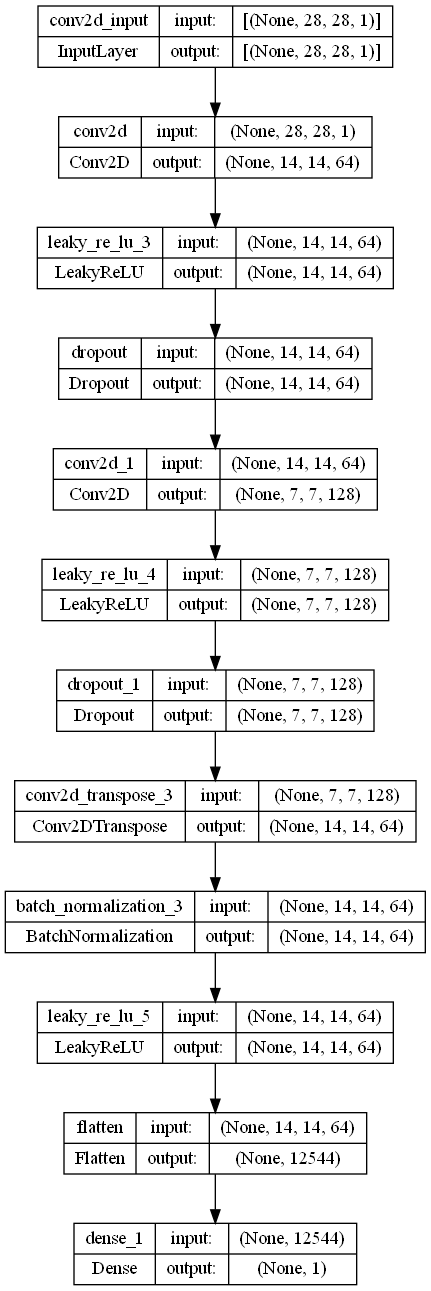

In [21]:
# Draw the diagram for the summary
plot_model(discriminator_model_emander, show_shapes=True, show_layer_names=True)

# Implement Training - 10 Epoch

In [22]:
cross_entropy_emander = keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer_emander = tf.keras.optimizers.Adam()
discriminator_optimizer_emander = tf.keras.optimizers.Adam()

In [23]:
def train_step(images):
    
    noise = tf.random.normal([256, 100])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator_model_emander(noise, training=True)

        real_output = discriminator_model_emander(images, training=True)
        fake_output = discriminator_model_emander(generated_images, training=True)
        
        gen_loss = cross_entropy_emander(tf.ones_like(fake_output), fake_output)
        real_loss = cross_entropy_emander(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy_emander(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_model_emander.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model_emander.trainable_variables)
    generator_optimizer_emander.apply_gradients(zip(gradients_of_generator, generator_model_emander.trainable_variables))
    discriminator_optimizer_emander.apply_gradients(zip(gradients_of_discriminator, discriminator_model_emander.trainable_variables))

In [24]:
import tensorflow as tf
import time

EPOCHS = 10
for epoch in range(EPOCHS):
    start = time.time()

    for image_batch in train_dataset_emander:
        train_step(image_batch)

    print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

C:\Users\emand\anaconda3\lib\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Time for epoch 1 is 22.900498151779175 sec
Time for epoch 2 is 21.854369163513184 sec
Time for epoch 3 is 21.663280248641968 sec
Time for epoch 4 is 23.108896493911743 sec
Time for epoch 5 is 22.820472240447998 sec
Time for epoch 6 is 22.597108602523804 sec
Time for epoch 7 is 22.693315029144287 sec
Time for epoch 8 is 22.69254469871521 sec
Time for epoch 9 is 23.04237961769104 sec
Time for epoch 10 is 23.487520217895508 sec


# Visualized Trained Generator

In [26]:
# Create 16 sample vectors
random_vectors = tf.random.normal([16, 100])

In [27]:
# Generate images from the sample vectors
generated_images = generator_model_emander(random_vectors, training=False)

In [28]:
# Normalize the pixels in the generated images to the [0,255] range
normalized_images = (generated_images * 127.5) + 127.5
normalized_images = normalized_images.numpy()  # Convert to numpy array if not already

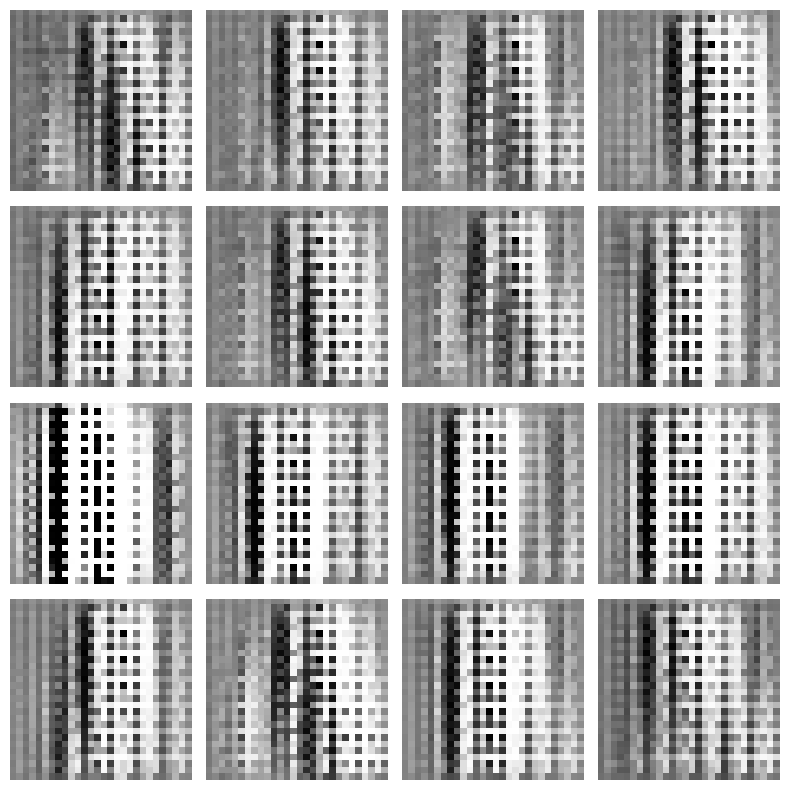

In [29]:
# Display the images
plt.figure(figsize=(8, 8))  # Set the figure size
for i in range(normalized_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(normalized_images[i, :, :, 0], cmap='gray')  # Adjust for grayscale
    plt.axis('off')

plt.tight_layout()
plt.show()

# Implement Training - 100 Epoch

In [35]:
import tensorflow as tf
import time

EPOCHS = 100
for epoch in range(EPOCHS):
    start = time.time()

    for image_batch in train_dataset_emander:
        train_step(image_batch)

    print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

Time for epoch 1 is 23.787012100219727 sec
Time for epoch 2 is 23.387187480926514 sec
Time for epoch 3 is 23.55075430870056 sec
Time for epoch 4 is 23.227577447891235 sec
Time for epoch 5 is 23.312284469604492 sec
Time for epoch 6 is 23.44121789932251 sec
Time for epoch 7 is 23.315975427627563 sec
Time for epoch 8 is 23.450556993484497 sec
Time for epoch 9 is 23.41677761077881 sec
Time for epoch 10 is 23.358543157577515 sec
Time for epoch 11 is 23.527428150177002 sec
Time for epoch 12 is 23.444164514541626 sec
Time for epoch 13 is 23.47379183769226 sec
Time for epoch 14 is 23.40844750404358 sec
Time for epoch 15 is 23.45018458366394 sec
Time for epoch 16 is 23.803276777267456 sec
Time for epoch 17 is 23.368540287017822 sec
Time for epoch 18 is 23.5022189617157 sec
Time for epoch 19 is 23.424325466156006 sec
Time for epoch 20 is 23.233157634735107 sec
Time for epoch 21 is 23.32348656654358 sec
Time for epoch 22 is 23.866859197616577 sec
Time for epoch 23 is 23.965161085128784 sec
Time f

In [36]:
# Create 16 sample vectors
random_vectors = tf.random.normal([16, 100])

In [37]:
# Generate images from the sample vectors
generated_images = generator_model_emander(random_vectors, training=False)

In [38]:
# Normalize the pixels in the generated images to the [0,255] range
normalized_images = (generated_images * 127.5) + 127.5
normalized_images = normalized_images.numpy()  # Convert to numpy array if not already

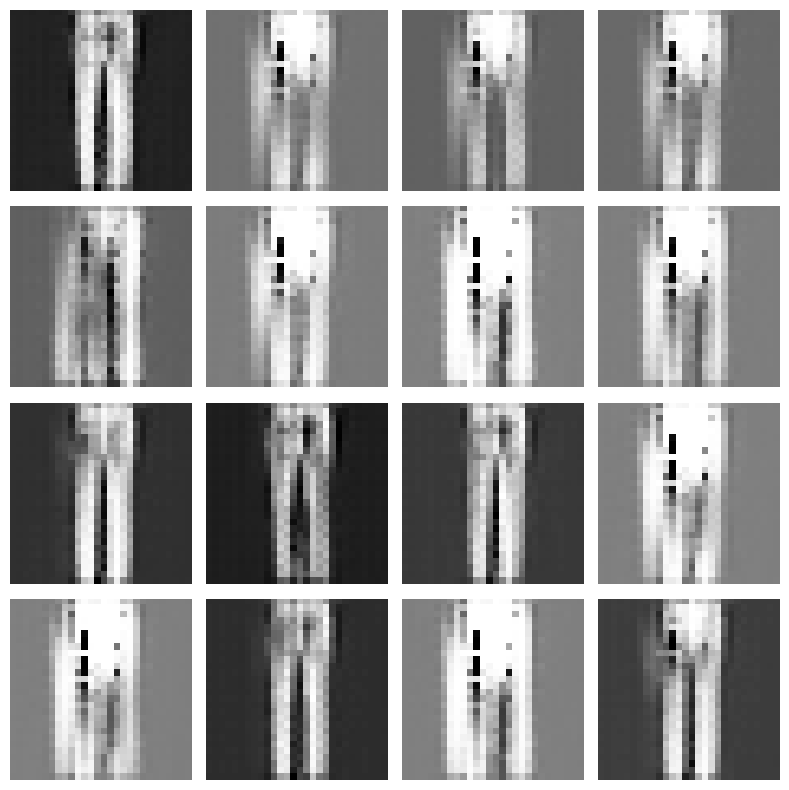

In [39]:
# Display the images
plt.figure(figsize=(8, 8))  # Set the figure size
for i in range(normalized_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(normalized_images[i, :, :, 0], cmap='gray')  # Adjust for grayscale
    plt.axis('off')

plt.tight_layout()
plt.show()